In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11323825824909350590, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10310869577910740776
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17203939132430425502
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6235600455911140496
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.2.0-rc3


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

 99% 1.02G/1.03G [00:16<00:00, 74.8MB/s]
100% 1.03G/1.03G [00:16<00:00, 66.6MB/s]


In [ ]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

In [ ]:
TRAINING_DIR = './asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = './asl_alphabet_test/asl_alphabet_test/'

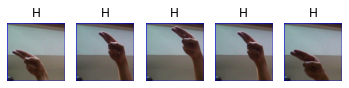

In [ ]:
%matplotlib inline

import cv2
import os
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

number_of_rows = 1
number_of_columns = 5

categories = os.listdir(TRAINING_DIR)

random.seed(13)

category = categories[random.randint(1, 30)]

for i in range(number_of_columns):
  subplot = plt.subplot(number_of_rows, number_of_columns, i + 1)
  subplot.axis('Off')
  subplot.set_title(category)
  image_path = os.path.join(
      TRAINING_DIR,
      str(category),
      str(category) + str(random.randint(1, 1000)) + '.jpg'
  )
  image = mpimg.imread(image_path)
  plt.imshow(image)
  
plt.show()


In [ ]:
# Preparing ImageDataGenerator object for training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [ ]:
train_generator.class_indices.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'])

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-03-01 10:19:12--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M  51.0MB/s    in 1.6s    

2020-03-01 10:19:14 (51.0 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Loading inception v3 network for transfer learning
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)


# Enabling the top 2 inception blocks to train
for layer in inception_v3_model.layers[:4]:
    layer.trainable = False
for layer in inception_v3_model.layers[4:]:
    layer.trainable = True
    
# Checking model summary to pick a layer (if required)
inception_v3_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 6s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 9

In [ ]:
# Choosing the output layer to be merged with our FC layers (if required)
#inception_output_layer = inception_v3_model.get_layer('mixed7')
#print('Inception model output shape:', inception_output_layer.output_shape)

#inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)                 
x = layers.Dense(29, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [ ]:

history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
100/100 [==============================] - 108s 1s/step - loss: 3.3745 - acc: 0.0539 - val_loss: 3.4619 - val_acc: 0.0625
Epoch 2/50
100/100 [==============================] - 90s 897ms/step - loss: 3.1583 - acc: 0.1498 - val_loss: 3.2264 - val_acc: 0.1116
Epoch 3/50
100/100 [==============================] - 90s 896ms/step - loss: 2.9365 - acc: 0.2992 - val_loss: 3.0679 - val_acc: 0.1925
Epoch 4/50
100/100 [==============================] - 90s 899ms/step - loss: 2.6711 - acc: 0.4470 - val_loss: 2.8673 - val_acc: 0.2966
Epoch 5/50
100/100 [==============================] - 90s 903ms/step - loss: 2.3608 - acc: 0.5833 - val_loss: 2.6487 - val_acc: 0.4087
Epoch 6/50
100/100 [==============================] - 90s 905ms/step - loss: 2.0452 - acc: 0.6859 - val_loss: 2.4279 - val_acc: 0.4966
Epoch 7/50
100/100 [==============================] - 89s 893ms/step - loss: 1.7428 - acc: 0.7584 - val_loss: 2.1284 - val_acc: 0.5953
Epoch 8/50
100/100 [==============================] - 90s

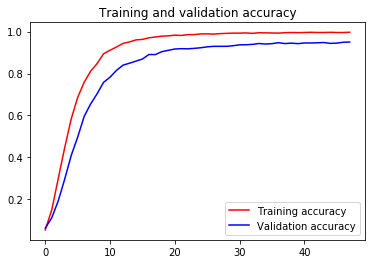

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

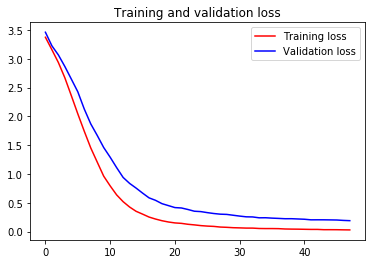

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                   
drive = GoogleDrive(gauth)

model.save('asl_inception_4_orig.h5')
model_file = drive.CreateFile({'title' : 'asl_inception_4_orig.h5'})   
model_file.SetContentFile('asl_inception_4_orig.h5')    
model_file.Upload()

# download to google drive                      
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '10qNlMRm1N-qI09Zqg18h_jWju-CXERj8'})

Actual class: A 
 Predicted class: A


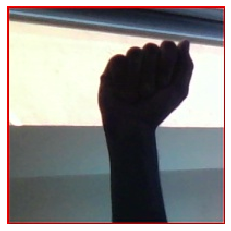

Actual class: T 
 Predicted class: T


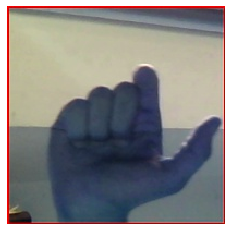

Actual class: M 
 Predicted class: N


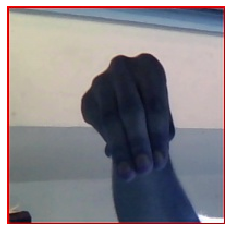

Actual class: E 
 Predicted class: E


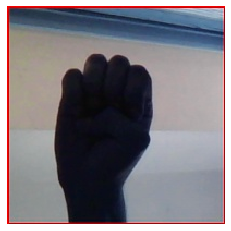

Actual class: K 
 Predicted class: K


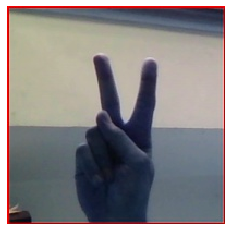

Actual class: N 
 Predicted class: N


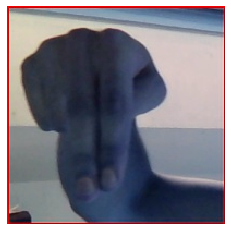

Actual class: U 
 Predicted class: U


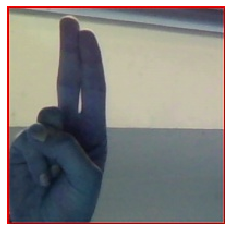

Actual class: D 
 Predicted class: D


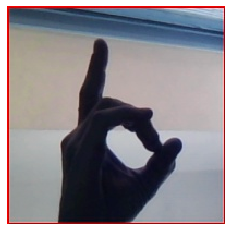

Actual class: O 
 Predicted class: O


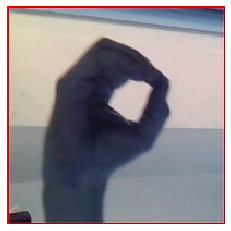

Actual class: L 
 Predicted class: L


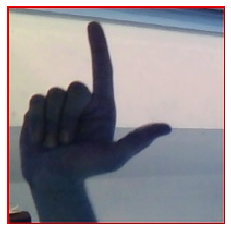

Actual class: Y 
 Predicted class: G


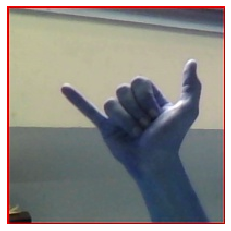

Actual class: I 
 Predicted class: I


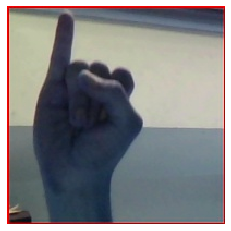

Actual class: F 
 Predicted class: F


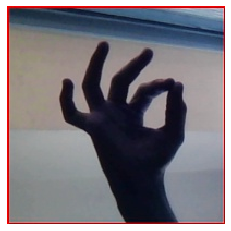

Actual class: nothing 
 Predicted class: nothing


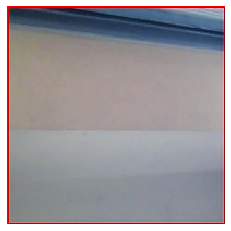

Actual class: J 
 Predicted class: J


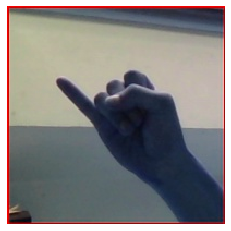

Actual class: X 
 Predicted class: X


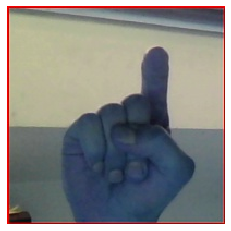

Actual class: G 
 Predicted class: G


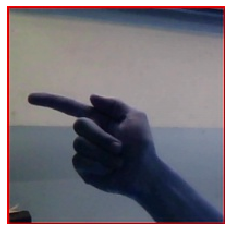

Actual class: P 
 Predicted class: P


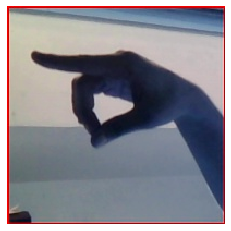

Actual class: C 
 Predicted class: C


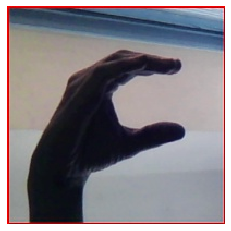

Actual class: S 
 Predicted class: S


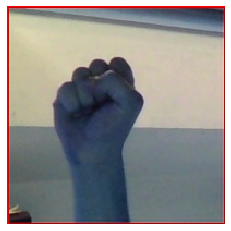

Actual class: W 
 Predicted class: W


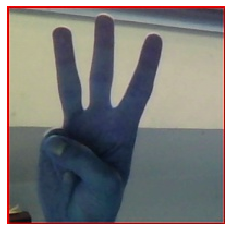

Actual class: R 
 Predicted class: R


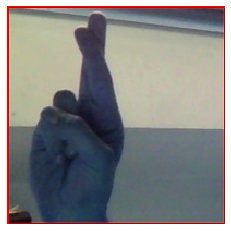

Actual class: space 
 Predicted class: space


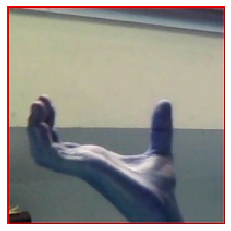

Actual class: B 
 Predicted class: B


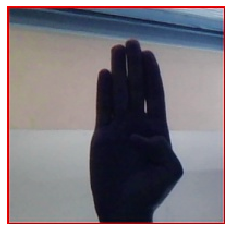

Actual class: V 
 Predicted class: V


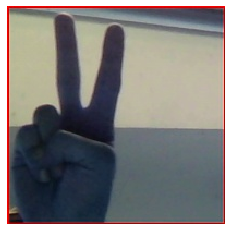

Actual class: Q 
 Predicted class: Q


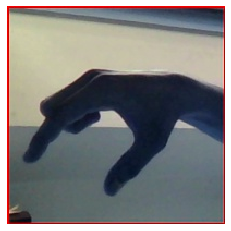

Actual class: H 
 Predicted class: H


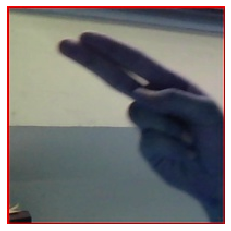

Actual class: Z 
 Predicted class: Z


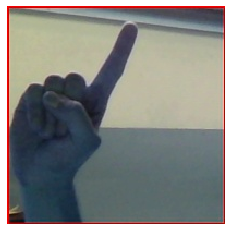

In [ ]:

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

classes = os.listdir(TRAINING_DIR)
classes.sort()

for i, test_image in enumerate(os.listdir(TEST_DIR)):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    plt.figure()
    plt.axis('Off')
    plt.imshow(img)
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    plt.show()

In [ ]:
classes = os.listdir(TRAINING_DIR)
classes.sort()
print(classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
test_images = os.listdir(TEST_DIR)
total_test_cases = len(test_images)
total_correctly_classified = 0
total_misclassified = 0
for i, test_image in enumerate(test_images):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} - Predicted class: {}'.format(
        actual, predicted), end=' ')
    if actual == predicted:
      print('PASS!')
      total_correctly_classified += 1
    else:
      print('FAIL!')
      total_misclassified += 1
print("=" * 20)
test_accuracy = (total_correctly_classified / total_test_cases) * 100
test_error_rate = (total_misclassified / total_test_cases) * 100

print('Test accuracy (%):', test_accuracy)
print('Test error rate (%):', test_error_rate)
print('Number of misclassified classes:', total_misclassified)
print('Number of correctly classified classes', total_correctly_classified)

Actual class: A - Predicted class: A PASS!
Actual class: T - Predicted class: T PASS!
Actual class: M - Predicted class: N FAIL!
Actual class: E - Predicted class: E PASS!
Actual class: K - Predicted class: K PASS!
Actual class: N - Predicted class: N PASS!
Actual class: U - Predicted class: U PASS!
Actual class: D - Predicted class: D PASS!
Actual class: O - Predicted class: O PASS!
Actual class: L - Predicted class: L PASS!
Actual class: Y - Predicted class: G FAIL!
Actual class: I - Predicted class: I PASS!
Actual class: F - Predicted class: F PASS!
Actual class: nothing - Predicted class: nothing PASS!
Actual class: J - Predicted class: J PASS!
Actual class: X - Predicted class: X PASS!
Actual class: G - Predicted class: G PASS!
Actual class: P - Predicted class: P PASS!
Actual class: C - Predicted class: C PASS!
Actual class: S - Predicted class: S PASS!
Actual class: W - Predicted class: W PASS!
Actual class: R - Predicted class: R PASS!
Actual class: space - Predicted class: spa

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving asl-alphabet-test_seperate.zip to asl-alphabet-test_seperate.zip


In [ ]:
!unzip asl-alphabet-test_seperate

Archive:  asl-alphabet-test_seperate.zip
   creating: asl-alphabet-test_seperate/A/
  inflating: asl-alphabet-test_seperate/A/A0001_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0002_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0003_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0004_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0005_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0006_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0007_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0008_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0009_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0010_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0011_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0012_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0013_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0014_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0015_test.jpg  
  inflating: asl-alphabet-test_

In [ ]:
import keras
test_batches_2 = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory("asl-alphabet-test_seperate",
                                                                                                                              target_size=(200,200),batch_size=870,shuffle=False)

Found 870 images belonging to 29 classes.


Using TensorFlow backend.


In [ ]:
test_labels = test_batches_2.classes;
test_batches_2.class_indices;

prediction_2 = model.predict_generator(test_batches_2);
prediction_2 = prediction_2.argmax(axis =1);

prediction_2.size

870

0.49770114942528737
              precision    recall  f1-score   support

           0       0.89      0.27      0.41        30
           1       0.91      0.33      0.49        30
           2       0.67      0.33      0.44        30
           3       0.79      0.37      0.50        30
           4       0.58      0.37      0.45        30
           5       0.40      0.60      0.48        30
           6       0.53      0.57      0.55        30
           7       0.50      0.90      0.64        30
           8       0.80      0.27      0.40        30
           9       0.64      0.47      0.54        30
          10       0.40      0.13      0.20        30
          11       1.00      0.53      0.70        30
          12       0.63      0.63      0.63        30
          13       0.74      0.67      0.70        30
          14       0.70      0.47      0.56        30
          15       0.43      0.73      0.54        30
          16       0.79      0.63      0.70        30
       

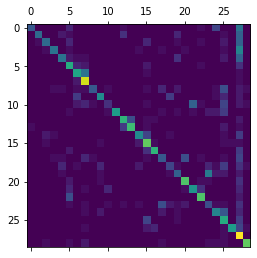

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(test_labels,prediction_2));
print(classification_report(test_labels,prediction_2));
cm_train = confusion_matrix(test_labels,prediction_2);
plt.matshow(cm_train);